In [46]:
# import diffeq_2 as methods
from scipy.integrate import odeint
import pydub
import time
from tqdm import tqdm
import math
from scipy import special, stats, optimize, fft, signal, linalg, integrate


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns
import pandas as pd
# sns.set_theme()

In [47]:
import matplotlib.animation as animation


## Prva GVP

Naloga je dokaj straight forward. Napisati moramo matriko, poiskat inverz in jo iterativno mnoziti z valovno funkcijo, ki pride. Pri implementaciji je smiselno namesto uporabe funkcije solve_banded najprej poiskati produkt inverza in konjugirani matrike, ker je ta matrika neodvisna od časa. To pomeni, da se s tem znebimo nepotrebnega iskanja inverza ter je koda precej hitrejša.

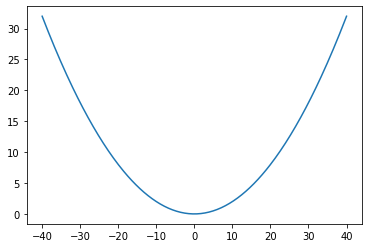

In [48]:
nihanji = 5

M = 1000 * nihanji
N = 300

k = 0.2**2
alpha = k**(1/4)
omega = np.sqrt(k)
lambda_p = 10


x = np.linspace(-40, 40, N)
delta_x = x[1] - x[0]


t = np.linspace(0, 2*np.pi/omega * nihanji, M)
delta_t = t[1] - t[0]


def V(x):
    return 1/2 * k * x**2


V_j = V(x)

plt.plot(x, V_j)

b = 1j * delta_t / (2 * delta_x**2)
# print(b)
a = -b/2


def d_j(j):
    return 1 + b + 1j * delta_t / 2 * V_j[j]


def tridiag(i, j, d, a):
    if i == j:
        return d(int(j))
    elif i+1 == j:
        return a
    elif i-1 == j:
        return a
    return 0


# def A_ij(i, j): return tridiag(i, j, d_j, a)
def A_ij(i, j): return tridiag(i, j, d_j, a)


A = np.fromfunction(np.vectorize(A_ij), (N, N))
A_inv_A_conj = np.dot(np.linalg.inv(A), np.matrix.conjugate(A))


def psi_0(x):
    return np.sqrt(alpha / np.sqrt(np.pi)) * np.exp(-alpha**2 * (x - lambda_p)**2 / 2)


Psi_0 = np.array(psi_0(x), dtype=complex)

# Psi_t = odeint(lambda y, t: np.dot(A_inv_A_conj, y), Psi_0, t)
Psi_t = np.empty((M, N), dtype=complex)
Psi_t[0] = Psi_0
for m in range(1, M):
    # Psi_t[m] = np.dot(A_inv_A_conj, Psi_t[m-1])
    Psi_t[m] = np.dot(A_inv_A_conj, Psi_t[m-1])


def psi_analitical(x, t):
    ksi = alpha*x
    ksi_lambda = alpha*lambda_p
    return np.sqrt(alpha / np.sqrt(np.pi)) * np.exp(
        -1/2 * (ksi - ksi_lambda * np.cos(omega * t))**2 - 1j * ( omega*t/2 + ksi*ksi_lambda*np.sin(omega * t) - 1/4 * ksi_lambda**2 * np.sin(2*omega*t))
    )


#! interesting this is not faster than default python
# def psi_ij(m,n): return psi_analitical(x[int(n)], t[int(m)])
# Psi_t_analitical = np.fromfunction(np.vectorize(psi_ij), (M, N))

Psi_t_analitical = np.empty((M, N), dtype=complex)
for m in range(M):
    for n in range(N):
        Psi_t_analitical[m, n] = psi_analitical(x[n], t[m])


Zanimiv opazek je, da python potrebuje relativno veliko časa, da izračuna analitično rešitev (17 sekund za miljon iteracij, kar je relativno veliko). Lahko bi paraleziral operacijo, vendar ni dovolj pomembno.

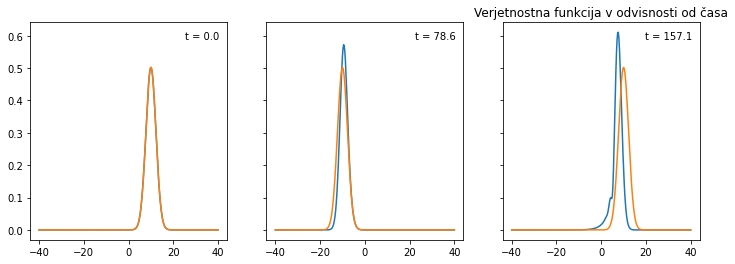

In [49]:
i = M//2

fig, axes = plt.subplots(1,3, figsize=(12,4), sharey=True)



i_s = [0, M//2, M-1]
for n, i in enumerate(i_s):
    ax = axes[n]
    ax.plot(x, np.abs(Psi_t[i]))
    ax.plot(x, np.abs(Psi_t_analitical[i]))
    ax.text(0.96, 0.96, f't = {round(t[i], 1)}', fontsize=10, ha='right', va='top',
            transform=axes[n].transAxes)

plt.title('Verjetnostna funkcija v odvisnosti od časa')

plt.savefig('grafi/verjetnostna_funkcija_v_odvisnosti_od_cas_1.pdf', bbox_inches='tight')
plt.show()

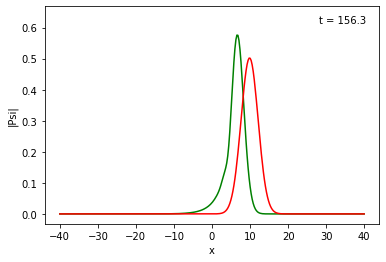

In [50]:
from celluloid import Camera

fig, ax = plt.subplots()
camera = Camera(fig)

plt.xlabel("x")
plt.ylabel("|Psi|")
# plt.legend()

for i in range(0,M, M//200):
    plt.plot(x, np.abs(Psi_t[i]), color='g')
    plt.plot(x, np.abs(Psi_t_analitical[i]), color='r')
    plt.text(0.96, 0.96, f't = {round(t[i], 1)}', fontsize=10, ha='right', va='top',
             transform=ax.transAxes)
    camera.snap()

animation = camera.animate()
animation.save('animacije/gausovka_razvoj.gif', writer='ffmpeg', fps=30)

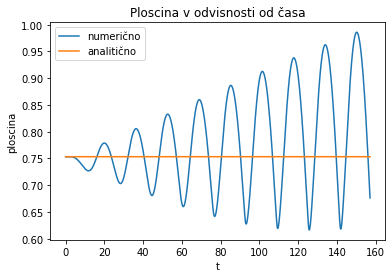

In [51]:
delta_x = x[1] - x[0]

ploscina_psi = np.zeros(Psi_t.shape[0])
ploscina_psi_analitical = np.zeros_like(ploscina_psi)

for i in range(0, M):
    ploscina_psi[i] = np.sum(np.abs(Psi_t[i])) * delta_x**2
    ploscina_psi_analitical[i] = np.sum(np.abs(Psi_t_analitical[i])) * delta_x**2

plt.title("Ploscina v odvisnosti od časa")
plt.plot(t, ploscina_psi, label="numerično")
plt.plot(t, ploscina_psi_analitical, label="analitično")

plt.xlabel("t")
plt.ylabel("ploscina")
plt.legend()
plt.savefig('grafi/ploscina_cas_1.pdf', bbox_inches='tight')

plt.show()


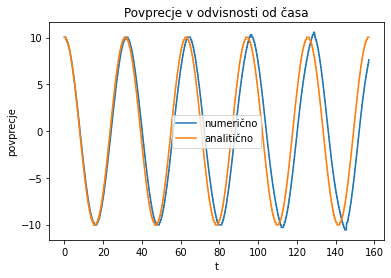

In [52]:
delta_x = x[1] - x[0]

povprecje_psi = np.zeros(Psi_t.shape[0])
povprecje_psi_analitical = np.zeros_like(povprecje_psi)

for i in range(0, M):
    povprecje_psi[i] = x[np.argmax(np.abs(Psi_t[i]))]
    povprecje_psi_analitical[i] = x[np.argmax(np.abs(Psi_t_analitical[i]))]

plt.title("Povprecje v odvisnosti od časa")
plt.plot(t, povprecje_psi, label="numerično")
plt.plot(t, povprecje_psi_analitical, label="analitično")

plt.xlabel("t")
plt.ylabel("povprecje")
plt.legend()

plt.savefig('grafi/povprecje_cas_1.pdf', bbox_inches='tight')


plt.show()


## Drugi del (prost GVP)

624


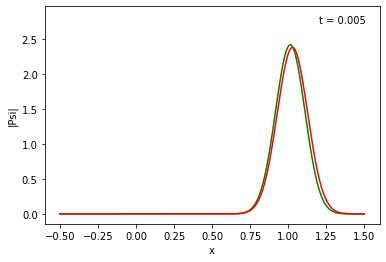

In [53]:
from celluloid import Camera
nihanji = 5

# M = 1000 * nihanji
N = 1000

k = 0.2**2
alpha = k**(1/4)
omega = np.sqrt(k)


rho_0 = 1/20
k_0 = 50*np.pi
lambda_p = 0.25


x = np.linspace(-0.5, 1.5, N)
delta_x = x[1] - x[0]

delta_t = 2*delta_x**2
t = np.arange(0, 5e-3, delta_t)
M = len(t)

print(M)


b = 1j * delta_t / (2 * delta_x**2)
# print(b)
a = -b/2


def d_j(j):
    return 1 + b  # + 1j * delta_t / 2 * V_j[j]


def tridiag(i, j, d, a):
    if i == j:
        return d(int(j))
    elif i+1 == j:
        return a
    elif i-1 == j:
        return a
    return 0


# def A_ij(i, j): return tridiag(i, j, d_j, a)
def A_ij(i, j): return tridiag(i, j, d_j, a)


A = np.fromfunction(np.vectorize(A_ij), (N, N))
A_inv_A_conj = np.dot(np.linalg.inv(A), np.matrix.conjugate(A))


def psi_0(x):
    return (2 * np.pi * rho_0**2)**(-1/4) * np.exp(1j * k_0 * (x-lambda_p)) * np.exp(-(x-lambda_p)**2 / (2 * rho_0)**2)


Psi_0 = np.array(psi_0(x), dtype=complex)

# plt.plot(x, Psi_0)

# Psi_t = odeint(lambda y, t: np.dot(A_inv_A_conj, y), Psi_0, t)
Psi_t_2 = np.empty((M, N), dtype=complex)
Psi_t_2[0] = Psi_0
for m in range(1, len(t)):
    # Psi_t[m] = np.dot(A_inv_A_conj, Psi_t[m-1])
    Psi_t_2[m] = np.dot(A_inv_A_conj, Psi_t_2[m-1])


def psi_analitical(x, t):
    return (2*np.pi*rho_0**2)**(-1/4) / np.sqrt(1 + 1j * t / (2*rho_0**2)) * np.exp(
        (-(x - lambda_p)**2 / (2*rho_0)**2 + 1j * k_0 * (x-lambda_p) - 1j * k_0**2 * t / 2) /
        (1 + 1j * t / (2*rho_0**2))
    )


#! interesting this is not faster than default python
# def psi_ij(m,n): return psi_analitical(x[int(n)], t[int(m)])
# Psi_t_analitical = np.fromfunction(np.vectorize(psi_ij), (M, N))

Psi_t_analitical_2 = np.empty((M, N), dtype=complex)
for m in range(len(t)):
    for n in range(N):
        Psi_t_analitical_2[m, n] = psi_analitical(x[n], t[m])


fig, ax = plt.subplots()
camera = Camera(fig)

plt.xlabel("x")
plt.ylabel("|Psi|")

for i in range(0, M, M//100):
    plt.plot(x, np.abs(Psi_t_2[i]), color='g', label="numerično")
    plt.plot(x, np.abs(Psi_t_analitical_2[i]), color='r', label="analitično")
    plt.text(0.96, 0.96, f't = {round(t[i], 4)}', fontsize=10, ha='right', va='top',
             transform=ax.transAxes)
    # plt.legend()
    camera.snap()

animation = camera.animate()
animation.save('animacije/potencial_0.gif', writer='ffmpeg', fps=30)


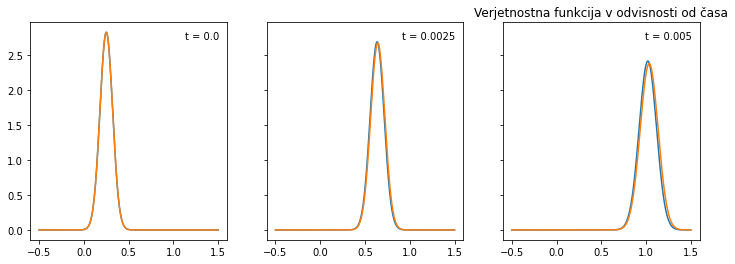

In [54]:
i = M//2

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)


i_s = [0, M//2, M-1]
for n, i in enumerate(i_s):
    ax = axes[n]
    ax.plot(x, np.abs(Psi_t_2[i]))
    ax.plot(x, np.abs(Psi_t_analitical_2[i]))
    ax.text(0.96, 0.96, f't = {round(t[i], 4)}', fontsize=10, ha='right', va='top',
            transform=axes[n].transAxes)

plt.title('Verjetnostna funkcija v odvisnosti od časa')

plt.savefig('grafi/verjetnostna_funkcija_v_odvisnosti_od_cas_2.pdf',
            bbox_inches='tight')


plt.show()


In [55]:
# from celluloid import Camera

# fig, ax = plt.subplots()
# camera = Camera(fig)

# plt.xlabel("x")
# plt.ylabel("|Psi|")

# for i in range(0, M, M//100):
#     plt.plot(x, np.abs(Psi_t_2[i]), color='g', label="numerično")
#     plt.plot(x, np.abs(Psi_t_analitical_2[i]), color='r', label="analitično")
#     plt.text(0.96, 0.96, f't = {round(t[i], 4)}', fontsize=10, ha='right', va='top',
#              transform=ax.transAxes)
#     # plt.legend()
#     camera.snap()

# animation = camera.animate()
# animation.save('animacije/potencial_0.gif', writer='ffmpeg', fps=30)


### Kako se premika maksimum (povprecje)?

Mogla bi se primikati enako za analiticno in numericno. Vendar numericna malce zaostaja.

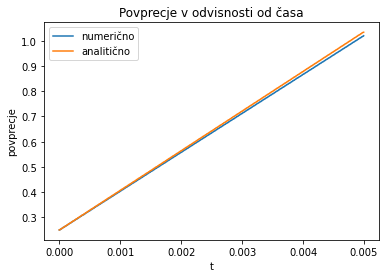

In [56]:
delta_x = x[1] - x[0]

povprecje_psi = np.zeros(Psi_t_2.shape[0])
povprecje_psi_analitical = np.zeros_like(povprecje_psi)

for i in range(0, M):
    povprecje_psi[i] = x[np.argmax(np.abs(Psi_t_2[i]))]
    povprecje_psi_analitical[i] = x[np.argmax(np.abs(Psi_t_analitical_2[i]))]

plt.title("Povprecje v odvisnosti od časa")
plt.plot(t, povprecje_psi, label="numerično")
plt.plot(t, povprecje_psi_analitical, label="analitično")

plt.xlabel("t")
plt.ylabel("povprecje")
plt.legend()

plt.savefig('grafi/povprecje_cas_2.pdf', bbox_inches='tight')

plt.show()

Povprečje malce zaostaja za analitično rešitvijo, vendar jo lahko poljubno prižamo analitični rešitvi. Kar moramo paziti je, da se numerična funkcija na robu vbistvu odbije in popolnoma zlomi, kar se zgodi, ker nimamo pravega robnega pogoja (oziroma računamo zgolj do roba, tako da se tam obnaša, kot da je stena).

1557


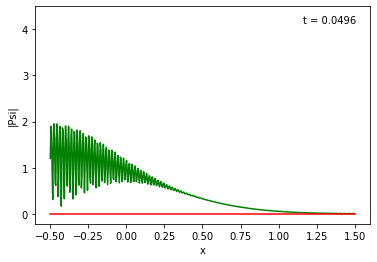

In [57]:
from celluloid import Camera
nihanji = 5

# M = 1000 * nihanji
N = 500

k = 0.2**2
alpha = k**(1/4)
omega = np.sqrt(k)


rho_0 = 1/20
k_0 = 50*np.pi
lambda_p = 0.25


x = np.linspace(-0.5, 1.5, N)
delta_x = x[1] - x[0]

delta_t = 2*delta_x**2
t = np.arange(0,5e-2, delta_t)
M = len(t)

print(M)


b = 1j * delta_t / (2 * delta_x**2)
# print(b)
a = -b/2


def d_j(j):
    return 1 + b  # + 1j * delta_t / 2 * V_j[j]


def tridiag(i, j, d, a):
    if i == j:
        return d(int(j))
    elif i+1 == j:
        return a
    elif i-1 == j:
        return a
    return 0


# def A_ij(i, j): return tridiag(i, j, d_j, a)
def A_ij(i, j): return tridiag(i, j, d_j, a)


A = np.fromfunction(np.vectorize(A_ij), (N, N))
A_inv_A_conj = np.dot(np.linalg.inv(A), np.matrix.conjugate(A))


def psi_0(x):
    return (2 * np.pi * rho_0**2)**(-1/4) * np.exp(1j * k_0 * (x-lambda_p)) * np.exp(-(x-lambda_p)**2 / (2 * rho_0)**2)


Psi_0 = np.array(psi_0(x), dtype=complex)

# plt.plot(x, Psi_0)

# Psi_t = odeint(lambda y, t: np.dot(A_inv_A_conj, y), Psi_0, t)
Psi_t_2 = np.empty((M, N), dtype=complex)
Psi_t_2[0] = Psi_0
for m in range(1, len(t)):
    # Psi_t[m] = np.dot(A_inv_A_conj, Psi_t[m-1])
    Psi_t_2[m] = np.dot(A_inv_A_conj, Psi_t_2[m-1])


def psi_analitical(x, t):
    return (2*np.pi*rho_0**2)**(-1/4) / np.sqrt(1 + 1j * t / (2*rho_0**2)) * np.exp(
        (-(x - lambda_p)**2 / (2*rho_0)**2 + 1j * k_0 * (x-lambda_p) - 1j * k_0**2 * t / 2) /
        (1 + 1j * t / (2*rho_0**2))
    )


#! interesting this is not faster than default python
# def psi_ij(m,n): return psi_analitical(x[int(n)], t[int(m)])
# Psi_t_analitical = np.fromfunction(np.vectorize(psi_ij), (M, N))

Psi_t_analitical_2 = np.empty((M, N), dtype=complex)
for m in range(len(t)):
    for n in range(N):
        Psi_t_analitical_2[m, n] = psi_analitical(x[n], t[m])


fig, ax = plt.subplots()
camera = Camera(fig)

plt.xlabel("x")
plt.ylabel("|Psi|")

for i in range(0, M, M//100):
    plt.plot(x, np.abs(Psi_t_2[i]), color='g', label="numerično")
    plt.plot(x, np.abs(Psi_t_analitical_2[i]), color='r', label="analitično")
    plt.text(0.96, 0.96, f't = {round(t[i], 4)}', fontsize=10, ha='right', va='top',
             transform=ax.transAxes)
    # plt.legend()
    camera.snap()

animation = camera.animate()
animation.save('animacije/potencial_0_zlom.gif', writer='ffmpeg', fps=30)
